# Net Present Value (NPV) and Internal Rate of Return (IRR) Calculator

## Overview

This notebook develops a comprehensive financial valuation toolkit for evaluating capital investment projects using **Net Present Value (NPV)** and **Internal Rate of Return (IRR)** metrics. These are fundamental tools in corporate finance for investment decision-making.

### Key Concepts

- **Net Present Value (NPV)**: The discounted value of all future cash flows, representing the net value added by the project
- **Internal Rate of Return (IRR)**: The discount rate that makes NPV = 0; the break-even return on investment
- **Discount Rate**: The required rate of return reflecting the time value of money
- **Root Finding**: Numerical methods (Bisection, Newton-Raphson) to solve NPV(r) = 0
- **NPV Profile**: Visualization of how NPV varies with different discount rates

---

## Mathematical Framework

### Net Present Value Formula

The NPV of a series of cash flows is calculated as:

$$\text{NPV}(r) = \sum_{t=0}^{n} \frac{C_t}{(1+r)^t}$$

where:
- $C_t$ = Cash flow at time $t$
- $r$ = Discount rate
- $n$ = Number of periods

### Internal Rate of Return

The IRR is the discount rate $r^*$ that satisfies:

$$\text{NPV}(r^*) = 0 \Rightarrow \sum_{t=0}^{n} \frac{C_t}{(1+r^*)^t} = 0$$

### First Derivative for Newton-Raphson Method

To use the Newton-Raphson root-finding method, we require:

$$\frac{d(\text{NPV})}{dr} = -\sum_{t=1}^{n} \frac{t \cdot C_t}{(1+r)^{t+1}}$$

---

## Function 1: Net Present Value Calculation

The `npv()` function computes the present value of all cash flows given a discount rate. It assumes the index in the cash flow array represents the time period.

In [2]:
def npv(cashflows, rate):
    """
    Calculate Net Present Value of a series of cash flows.
    
    Parameters:
    -----------
    cashflows : list or array
        Cash flows where index represents time period
    rate : float
        Discount rate (e.g., 0.10 for 10%)
    
    Returns:
    --------
    float
        Net Present Value
    """
    try:
        discount = []
        for year in range(len(cashflows)):
            discount.append(cashflows[year] / (1 + rate) ** year)
        
        result = sum(discount)
        return result
    
    except TypeError:
        print(f"Error: The element {cashflows[year]} is not a number")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

### Example 1: NPV Calculation

Let's calculate the NPV of a cash flow stream at a 12% discount rate.

In [3]:
# Example cash flows: Initial investment followed by positive inflows
cashflows_example = [2000.0, 3000, 4556.67, 5346.65]
discount_rate = 0.12

# Calculate NPV
npv_result = npv(cashflows_example, discount_rate)

print(f"Cash Flow Stream: {cashflows_example}")
print(f"Discount Rate: {discount_rate*100:.1f}%")
print(f"NPV: ${npv_result:,.2f}")

Cash Flow Stream: [2000.0, 3000, 4556.67, 5346.65]
Discount Rate: 12.0%
NPV: $12,116.76


## Function 2: Derivative of NPV Function

For numerical optimization using Newton-Raphson method, we need the derivative of NPV with respect to the discount rate.

In [4]:
def dnpv(cashflows, r):
    """
    Calculate the first derivative of NPV function with respect to discount rate.
    Used exclusively with irr_newton_raphson() for root finding.
    
    d(NPV)/dr = -Σ[t * C_t / (1+r)^(t+1)] for t = 0 to n
    
    Parameters:
    -----------
    cashflows : list or array
        Cash flows
    r : float
        Discount rate
    
    Returns:
    --------
    float
        Derivative of NPV with respect to r
    """
    try:
        d_discount = [cashflows[0]]  # First term is constant
        for year in range(1, len(cashflows)):
            d_discount.append(
                (-year * cashflows[year]) / (1 + r) ** (year + 1)
            )
        
        result = sum(d_discount)
        return result
    
    except TypeError:
        print(f"Error: The element {cashflows[year]} is not a number")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

## Function 3: IRR Using Newton-Raphson Method

The Newton-Raphson method is an efficient iterative algorithm for finding IRR. It uses both the function value and its derivative to rapidly converge to the root.

In [5]:
def irr_newton_raphson(cashflows, low_rate, high_rate, n_rates):
    """
    Calculate Internal Rate of Return using Newton-Raphson method.
    
    Algorithm:
    1. Generate initial guesses uniformly spaced between [low_rate, high_rate]
    2. For each initial guess, apply Newton-Raphson iteration
    3. Convergence criterion: |next_guess - current_guess| < delta
    4. Remove duplicate roots (within tolerance)
    
    Parameters:
    -----------
    cashflows : list
        Cash flow sequence
    low_rate : float
        Lower bound for initial guesses
    high_rate : float
        Upper bound for initial guesses
    n_rates : int
        Number of initial guesses to try
    
    Returns:
    --------
    list
        List of found IRR values
    """
    try:
        start = low_rate
        end = high_rate
        N = n_rates
        step = (end - start) / (N - 1)
        
        # Generate initial guesses
        r_values = [start + i * step for i in range(N)]
        
        # Parameters for Newton-Raphson iteration
        delta = 1e-10  # Convergence tolerance
        roots = []
        
        # Try each initial guess
        for x in r_values:
            guess = x
            
            # Iterate until convergence
            for iteration in range(1000):
                npv_val = npv(cashflows, guess)
                dnpv_val = dnpv(cashflows, guess)
                
                # Newton-Raphson step
                next_guess = guess - npv_val / dnpv_val
                
                # Check convergence
                if abs(next_guess - guess) < delta:
                    # Check if this root is already found
                    is_duplicate = False
                    for root in roots:
                        if abs(root - next_guess) < 1e-6:
                            is_duplicate = True
                            break
                    
                    if not is_duplicate:
                        roots.append(next_guess)
                    break
                
                guess = next_guess
        
        return roots
    
    except ZeroDivisionError:
        print("Error: Division by zero in Newton-Raphson (derivative = 0)")
        return []
    except Exception as e:
        print(f"Error in Newton-Raphson: {e}")
        return []

### Example 2: IRR Using Newton-Raphson

Calculate the IRR of an annuity-like cash flow stream.

In [6]:
# Example: Investment project
annuity_cashflows = [-50000, 25000, 15000, 15000, 15000]

# Calculate IRR using Newton-Raphson
irr_values = irr_newton_raphson(annuity_cashflows, 0.06, 0.15, 10**4)

print(f"Cash Flow Stream: {annuity_cashflows}")
print(f"\nIRR Calculation Results:")
print(f"-" * 50)

if irr_values:
    for i, irr in enumerate(irr_values, 1):
        print(f"IRR #{i}: {irr:.10f} ({irr*100:.6f}%)")
        # Verify: NPV at IRR should be ~0
        npv_at_irr = npv(annuity_cashflows, irr)
        print(f"  Verification - NPV @ IRR: ${npv_at_irr:.2e}")
else:
    print("No IRR found in the specified range")

Cash Flow Stream: [-50000, 25000, 15000, 15000, 15000]

IRR Calculation Results:
--------------------------------------------------
IRR #1: 0.1665734105 (16.657341%)
  Verification - NPV @ IRR: $1.81e-06


## Function 4: IRR Using Bisection Method

The Bisection method is a robust root-finding algorithm that works when the NPV function changes sign. It's slower than Newton-Raphson but more stable.

In [7]:
def irr_bisection(cash_flows, low_rate, high_rate, max_iterations=1000, tolerance=1e-6):
    """
    Calculate Internal Rate of Return using Bisection method.
    
    Requirements:
    - NPV at low_rate and high_rate must have opposite signs
    - This method always converges if conditions are met
    
    Parameters:
    -----------
    cash_flows : list
        Cash flow sequence
    low_rate : float
        Lower bound (must have NPV(low) * NPV(high) < 0)
    high_rate : float
        Upper bound
    max_iterations : int
        Maximum iterations
    tolerance : float
        Convergence tolerance
    
    Returns:
    --------
    float or None
        IRR value if found, None otherwise
    """
    try:
        npv_low = npv(cash_flows, low_rate)
        npv_high = npv(cash_flows, high_rate)
        
        # Check that signs are opposite
        if npv_low * npv_high >= 0:
            raise ValueError(
                f"Bisection requires opposite signs: NPV(low)={npv_low:.4f}, "
                f"NPV(high)={npv_high:.4f}"
            )
        
        rate = 0.0
        for iteration in range(max_iterations):
            # Calculate midpoint
            rate = (low_rate + high_rate) / 2
            npv_mid = npv(cash_flows, rate)
            
            # Check convergence
            if (abs(npv_mid) < tolerance or
                abs(high_rate - low_rate) / 2 < tolerance):
                return rate
            
            # Decide which half to search next
            if npv_mid * npv_low < 0:
                # Root is in lower half
                high_rate = rate
            else:
                # Root is in upper half
                low_rate = rate
                npv_low = npv_mid
        
        raise RuntimeError(
            f"Bisection did not converge within {max_iterations} iterations"
        )
    
    except ValueError as e:
        print(f"ValueError: {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

### Example 3: IRR Using Bisection Method

Calculate the IRR of a simple investment project using the robust Bisection method.

In [8]:
# Example: Simple investment project
project_cashflows = [-10000, 3000, 4000, 5000]

# Calculate IRR using Bisection
irr_bisection_result = irr_bisection(project_cashflows, -0.99, 10.0)

print(f"Cash Flow Stream: {project_cashflows}")
print(f"\nBisection Method Results:")
print(f"-" * 50)

if irr_bisection_result is not None:
    print(f"IRR: {irr_bisection_result:.10f}")
    print(f"IRR (percentage): {irr_bisection_result*100:.6f}%")
    
    # Verify
    npv_at_irr = npv(project_cashflows, irr_bisection_result)
    print(f"\nVerification:")
    print(f"NPV @ IRR: ${npv_at_irr:.2e} (should be ≈ 0)")
else:
    print("IRR could not be calculated")

Cash Flow Stream: [-10000, 3000, 4000, 5000]

Bisection Method Results:
--------------------------------------------------
IRR: 0.0889627832
IRR (percentage): 8.896278%

Verification:
NPV @ IRR: $1.19e-02 (should be ≈ 0)


## NPV Profile Analysis

The NPV Profile shows how NPV varies across different discount rates, making it easy to visualize the IRR (where the profile crosses the x-axis).

In [34]:
import matplotlib.pyplot as plt

def create_npv_profile_multiple_irrs(cash_flows, rate_min=-0.20, rate_max=2.00, n_points=1000):
    """
    Create NPV profile plot that handles multiple IRRs
    WITHOUT using NumPy - pure Python only!
    
    Parameters:
    -----------
    cash_flows : list
        Cash flow sequence
    rate_min : float
        Minimum discount rate (e.g., -0.20 for -20%)
    rate_max : float
        Maximum discount rate (e.g., 2.00 for 200%)
    n_points : int
        Number of points to plot (higher = smoother curve)
    """
    
    # Generate rate range WITHOUT numpy.linspace
    step = (rate_max - rate_min) / (n_points - 1)
    rates = [rate_min + i * step for i in range(n_points)]
    
    # Calculate NPV for each rate
    npv_vals = [npv(cash_flows, r) for r in rates]
    
    # Convert rates to percentages for plotting
    rates_pct = [r * 100 for r in rates]
    
    # Find all IRRs
    print("Searching for IRRs...")
    all_irrs = irr_newton_raphson(cash_flows, rate_min, rate_max, 10000)
    
    # Filter IRRs within our display range
    valid_irrs = [irr for irr in all_irrs if rate_min <= irr <= rate_max]
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    plt.plot(rates_pct, npv_vals, linewidth=2.5, color='steelblue', 
             label=f'NPV Profile ({len(valid_irrs)} IRR{"s" if len(valid_irrs) != 1 else ""})')
    
    # Horizontal line at NPV = 0
    plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.7)
    
    # Define colors for different IRRs
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']
    
    # Mark all IRRs found
    if valid_irrs:
        print(f"\n{'='*60}")
        print(f"Found {len(valid_irrs)} IRR(s) for cash flows: {cash_flows}")
        print(f"{'='*60}")
        
        for i, irr_val in enumerate(valid_irrs):
            irr_pct = irr_val * 100
            npv_at_irr = npv(cash_flows, irr_val)
            
            print(f"IRR #{i+1}: {irr_pct:.4f}% (NPV = ${npv_at_irr:.2f})")
            
            color = colors[i % len(colors)]
            
            # Vertical line at IRR
            plt.axvline(irr_pct, color=color, linestyle='--', 
                       linewidth=1.5, alpha=0.7, label=f'IRR #{i+1}')
            
            # Mark the point
            plt.plot(irr_pct, npv_at_irr, 'o', color=color, 
                    markersize=10, zorder=5)
            
            # Calculate annotation position (avoid overlap)
            # Find max NPV for positioning
            max_npv = max(npv_vals)
            min_npv = min(npv_vals)
            npv_range = max_npv - min_npv
            
            # Stagger annotations vertically
            y_offset = max_npv - (i * npv_range * 0.15)
            
            # Annotate
            plt.annotate(f'IRR #{i+1} = {irr_pct:.2f}%',
                        xy=(irr_pct, npv_at_irr),
                        xytext=(irr_pct + 5, y_offset),
                        arrowprops=dict(arrowstyle='->', color=color, lw=1.5),
                        fontsize=10,
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.5', 
                                fc='white', ec=color, lw=2, alpha=0.9))
    else:
        print("\n⚠️  No IRR found in the specified range!")
        plt.text(0.5, 0.5, 'No IRR Found', 
                transform=plt.gca().transAxes,
                fontsize=16, color='red', ha='center',
                bbox=dict(boxstyle='round', fc='yellow', alpha=0.7))
    
    plt.xlabel('Discount Rate (%)', fontsize=13, fontweight='bold')
    plt.ylabel('NPV ($)', fontsize=13, fontweight='bold')
    plt.title(f'NPV Profile with {"Multiple " if len(valid_irrs) > 1 else ""}IRR{"s" if len(valid_irrs) != 1 else ""}\n' +
              f'Cash Flows: {cash_flows}', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.show()
    
    print(f"{'='*60}\n")



EXAMPLE 1: Conventional Cash Flows (Single IRR)
Searching for IRRs...

Found 1 IRR(s) for cash flows: [-10000, 3000, 4000, 5000]
IRR #1: 8.8963% (NPV = $0.00)


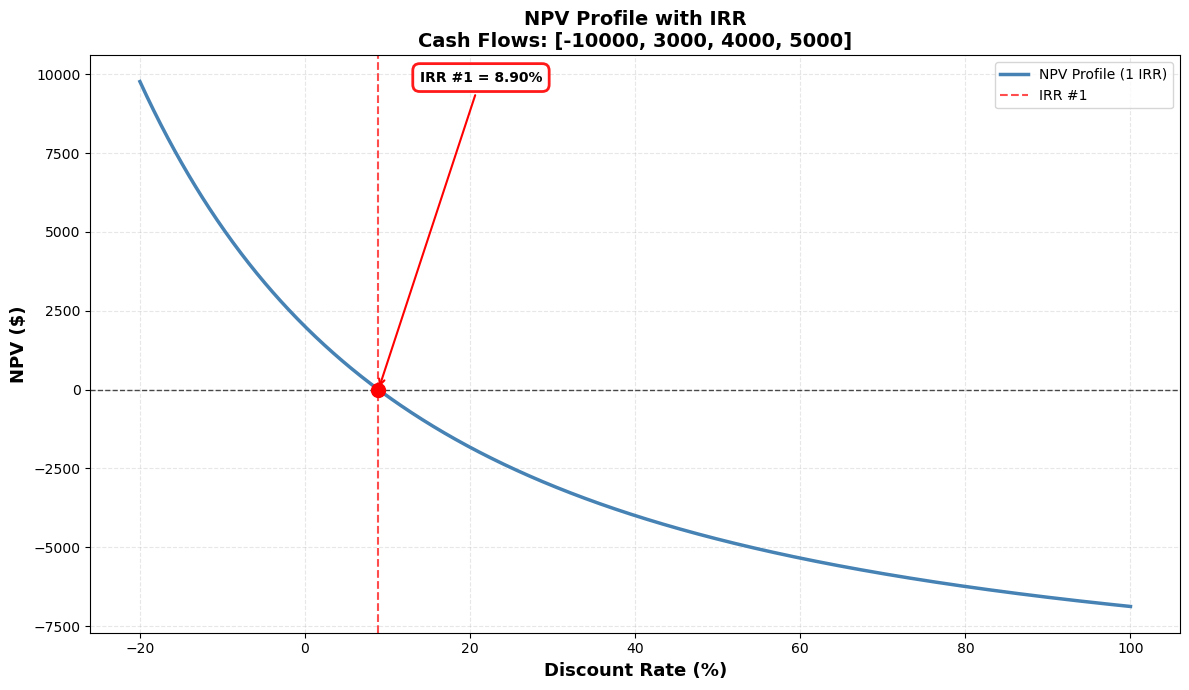

In [35]:
print("\n" + "="*70)
print("EXAMPLE 1: Conventional Cash Flows (Single IRR)")
print("="*70)
cash_flows_1 = [-10000, 3000, 4000, 5000]
create_npv_profile_multiple_irrs(cash_flows_1, rate_min=-0.20, rate_max=1.00)


EXAMPLE: Two Real IRRs (0% and 100%)
Searching for IRRs...

Found 2 IRR(s) for cash flows: [-5000, 15000, -12000, 8000, -3000]
IRR #1: -41.3272% (NPV = $-0.00)
IRR #2: 117.7017% (NPV = $-0.00)


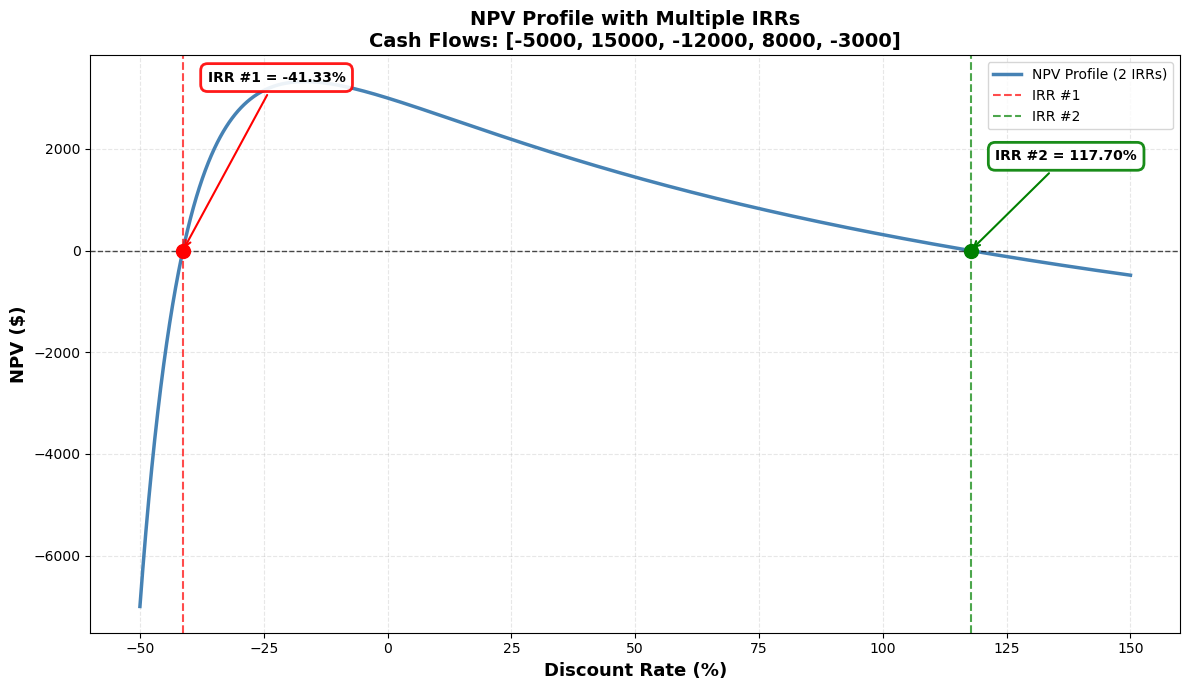

In [45]:
print("\n" + "="*70)
print("EXAMPLE: Two Real IRRs (0% and 100%)")
print("="*70)
cash_flows_2irr = [-5000, 15000, -12000, 8000, -3000]
create_npv_profile_multiple_irrs(cash_flows_2irr, rate_min=-0.50, rate_max=1.50)


## Sensitivity Analysis: NPV at Different Discount Rates

A summary table showing how NPV changes across key discount rates.

In [10]:
# Summary table of NPV at different discount rates
test_rates = [0.00, 0.05, 0.10, 0.15, 0.20]

print("\nNPV Sensitivity Analysis")
print("="*60)
print(f"{'Discount Rate':<15} {'NPV':>20}")
print("-"*60)

for r in test_rates:
    npv_val = npv(project_cashflows, r)
    print(f"{r*100:>6.1f}%{'':<7} ${npv_val:>18,.2f}")

print("-"*60)
print("\nInterpretation:")
print("• When NPV > 0: Project adds value (Accept if r is required return)")
print("• When NPV = 0: Discount rate equals IRR (Break-even point)")
print("• When NPV < 0: Project destroys value (Reject)")


NPV Sensitivity Analysis
Discount Rate                    NPV
------------------------------------------------------------
   0.0%        $          2,000.00
   5.0%        $            804.45
  10.0%        $           -210.37
  15.0%        $         -1,079.15
  20.0%        $         -1,828.70
------------------------------------------------------------

Interpretation:
• When NPV > 0: Project adds value (Accept if r is required return)
• When NPV = 0: Discount rate equals IRR (Break-even point)
• When NPV < 0: Project destroys value (Reject)


## Summary and Decision Rules

### NPV Decision Rule
- **Accept** the project if NPV > 0
- **Reject** the project if NPV < 0
- **Indifferent** if NPV = 0

### IRR Decision Rule
- **Accept** the project if IRR > required return
- **Reject** the project if IRR < required return
- **Indifferent** if IRR = required return

### Advantages and Limitations

| Aspect | NPV | IRR |
|--------|-----|-----|
| **Interpretation** | Dollar value added | Percentage return |
| **Uniqueness** | Always unique | May have multiple roots |
| **Ranking** | Consistent with value | Can rank incorrectly |
| **Reinvestment Rate** | Explicit (discount rate) | Assumes reinvestment at IRR |
| **Intuition** | Less intuitive | More intuitive |

---